In [1]:
from __future__ import division
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid

from composition.analysis.load_sim import load_sim
from composition.analysis.preprocessing import get_train_test_sets, LabelEncoder
from composition.analysis.pipelines import get_pipeline
from composition.analysis.features import get_training_features
from composition.analysis.plotting_functions import plot_decision_regions
import composition.analysis.data_functions as data_functions
from composition.support_functions.checkdir import checkdir

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sns.set_palette('muted')
sns.set_color_codes()

In [3]:
df, cut_dict = load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                     'StationDensity', 'max_charge_frac', 'reco_containment', 'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list = get_training_features()
X_train, X_test, y_train, y_test, le = get_train_test_sets(df, feature_list)

print('events = ' + str(y_train.shape[0]))

/home/jbourbeau/composition/analysis/load_sim.py:67: RuntimeWarning: divide by zero encountered in log10
  df['reco_log_energy'] = np.nan_to_num(np.log10(df['reco_energy']))
/home/jbourbeau/composition/analysis/load_sim.py:68: RuntimeWarning: invalid value encountered in log10
  df['InIce_log_charge'] = np.nan_to_num(np.log10(df['InIce_charge']))


events = 72644


[CV] classifier__nu=0.0001 ...........................................
[CV] classifier__nu=0.1001 ...........................................
[CV] classifier__nu=0.2001 ...........................................
[CV] classifier__nu=0.3001 ...........................................
[CV] classifier__nu=0.4001 ...........................................
[CV] classifier__nu=0.0001 ...........................................
[CV] classifier__nu=0.1001 ...........................................
[CV] classifier__nu=0.2001 ...........................................
[CV] classifier__nu=0.3001 ...........................................
[CV] classifier__nu=0.4001 ...........................................
[CV] .................. classifier__nu=0.0001, score=0.577122 -   0.1s
[CV] classifier__nu=0.0001 ...........................................
[CV] .................. classifier__nu=0.0001, score=0.497212 -   0.1s
[CV] classifier__nu=0.1001 ...........................................
[CV] .

[Parallel(n_jobs=10)]: Done   8 out of  25 | elapsed:  7.0min remaining: 15.0min


[CV] .................. classifier__nu=0.2001, score=0.653589 -   9.7s
[CV] classifier__nu=0.3001 ...........................................
[CV] .................. classifier__nu=0.2001, score=0.572992 -  11.1s
[CV] classifier__nu=0.4001 ...........................................
[CV] .................. classifier__nu=0.1001, score=0.499140 -   6.4s
[CV] classifier__nu=0.0001 ...........................................
[CV] .................. classifier__nu=0.0001, score=0.434127 -   0.1s
[CV] classifier__nu=0.1001 ...........................................
[CV] .................. classifier__nu=0.3001, score=0.416133 -  13.1s
[CV] classifier__nu=0.2001 ...........................................
[CV] .................. classifier__nu=0.3001, score=0.446968 -  13.5s
[CV] classifier__nu=0.3001 ...........................................
[CV] .................. classifier__nu=0.2001, score=0.633905 -  10.1s
[CV] classifier__nu=0.4001 ...........................................
[CV] .

[Parallel(n_jobs=10)]: Done  17 out of  25 | elapsed: 15.8min remaining:  7.4min


[CV] .................. classifier__nu=0.3001, score=0.675958 -  13.1s
[CV] .................. classifier__nu=0.4001, score=0.708170 -  16.3s
[CV] .................. classifier__nu=0.2001, score=0.646338 -   9.8s
[CV] .................. classifier__nu=0.3001, score=0.622961 -  13.3s
[CV] .................. classifier__nu=0.4001, score=0.691032 -  16.2s
[CV] .................. classifier__nu=0.3001, score=0.609444 -  12.3s
[CV] .................. classifier__nu=0.4001, score=0.717049 -  15.4s
[CV] .................. classifier__nu=0.4001, score=0.658728 -  14.9s


[Parallel(n_jobs=10)]: Done  25 out of  25 | elapsed: 29.0min finished


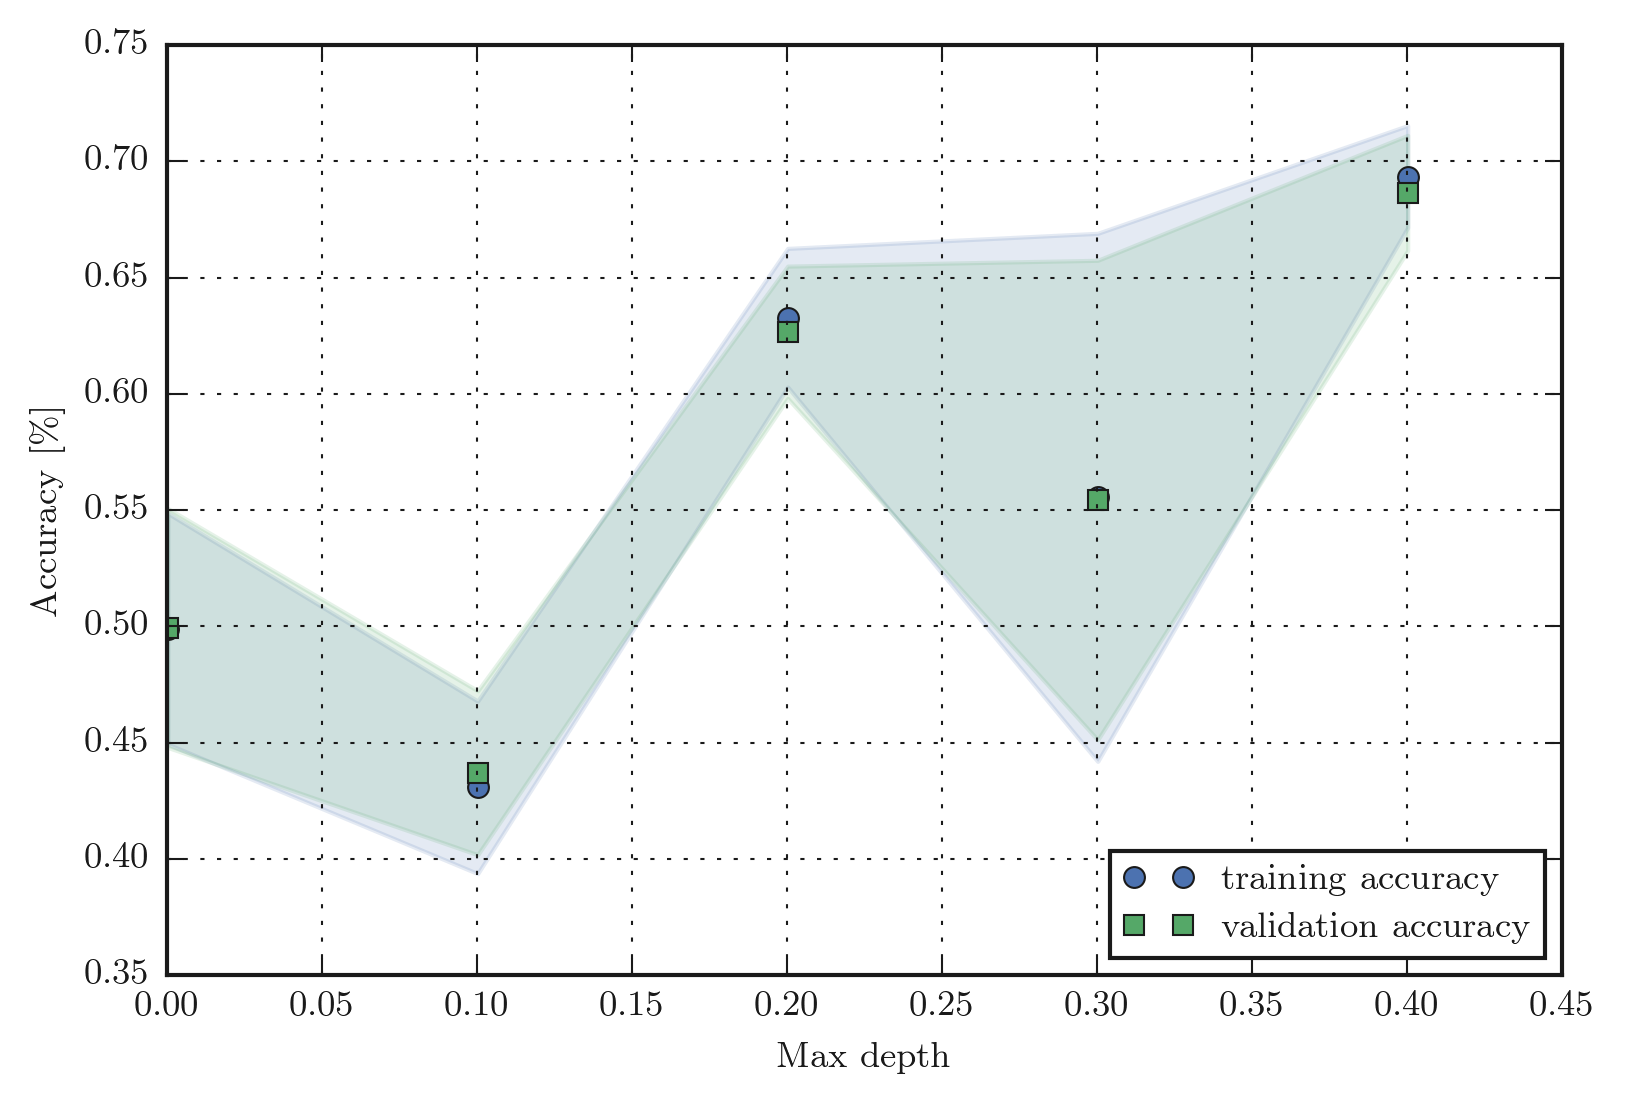

In [5]:
pipeline = get_pipeline('NuSVC')
param_range = np.arange(0.0001, 0.5, 0.1)
train_scores, test_scores = validation_curve(
                estimator=pipeline, 
                X=X_train, 
                y=y_train, 
                param_name='classifier__nu', 
                param_range=param_range,
                cv=5,
                verbose=3,
                n_jobs=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='b', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='b')

plt.plot(param_range, test_mean, 
         color='g', linestyle='None', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='g')

plt.grid()
# plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Max depth')
plt.ylabel('Accuracy [\%]')
# plt.ylim([0.8, 1.0])
# plt.tight_layout()
plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/SVC-validation_curve.png', dpi=300)
# plt.show()

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


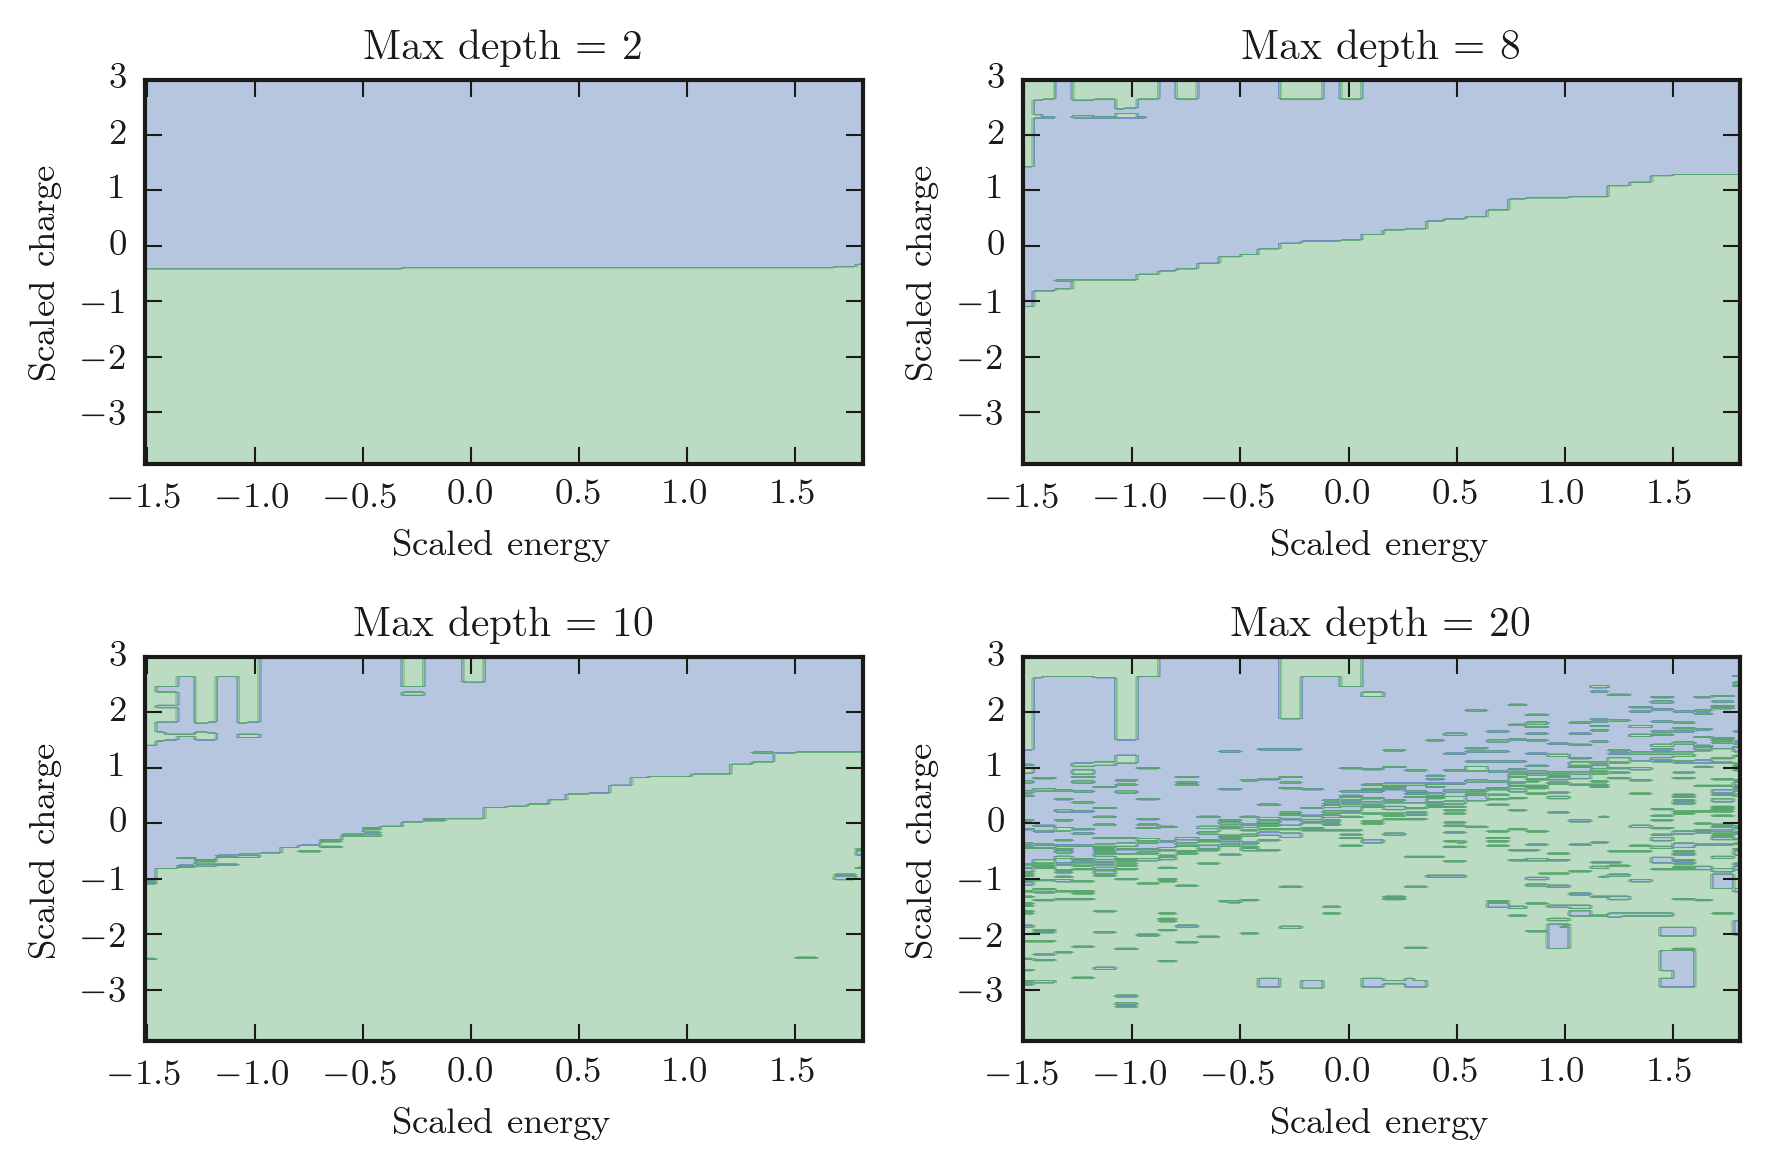

In [4]:
max_depth_list = [2, 8, 10, 20]

fig, axarr = plt.subplots(2,2)
for depth, ax in zip(max_depth_list, axarr.flatten()):
    pipeline = get_pipeline('RF')
    pipeline.named_steps['classifier'].set_params(max_depth=depth)
    pipeline.fit(X_train, y_train)
    scaler = pipeline.named_steps['scaler']
    clf = pipeline.named_steps['classifier']
    X_test_std = scaler.transform(X_test)
    plot_decision_regions(X_test_std, y_test, clf, scatter_fraction=None, ax=ax)
    ax.set_xlabel('Scaled energy')
    ax.set_ylabel('Scaled charge')
    ax.set_title('Max depth = {}'.format(depth))
    ax.legend()
plt.tight_layout()
plt.savefig('/home/jbourbeau/public_html/figures/composition/parameter-tuning/RF-decision-regions.png')


In [5]:
pipeline = get_pipeline('RF')
param_range = np.arange(1, 20)
param_grid = {'classifier__max_depth': param_range}
gs = GridSearchCV(estimator=pipeline, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7872226199
{'classifier__max_depth': 10}
